
# Reconocimento de voz femenina o masculina basandose en las propiedades acusticas de la voz.

Fuente:
https://www.kaggle.com/primaryobjects/voicegender

# Importando librerias necesarias


In [ ]:
#import utils, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 


# Utils

In [127]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def Visualization_tree(model,y_train,featureNames,targetNames):
    dot_data = StringIO()
    filename = "voz_tree.png"
    featureNames = featureNames
    targetNames = targetNames
    out=tree.export_graphviz(model,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(filename)
    img = mpimg.imread(filename)
    plt.figure(figsize=(100, 200))
    plt.imshow(img,interpolation='nearest')

# Carga de datos

In [3]:
# Usamos pandas para cargar el archivo csv:
df = pd.read_csv('voice.csv')
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [4]:
#vemos num de filas y columnas
df.shape

(3168, 21)

In [5]:
#tipos de datos
df.dtypes

meanfreq    float64
sd          float64
median      float64
Q25         float64
Q75         float64
IQR         float64
skew        float64
kurt        float64
sp.ent      float64
sfm         float64
mode        float64
centroid    float64
meanfun     float64
minfun      float64
maxfun      float64
meandom     float64
mindom      float64
maxdom      float64
dfrange     float64
modindx     float64
label        object
dtype: object

In [6]:
# % de datos faltantes
df.isna().sum() / len(df)

meanfreq    0.0
sd          0.0
median      0.0
Q25         0.0
Q75         0.0
IQR         0.0
skew        0.0
kurt        0.0
sp.ent      0.0
sfm         0.0
mode        0.0
centroid    0.0
meanfun     0.0
minfun      0.0
maxfun      0.0
meandom     0.0
mindom      0.0
maxdom      0.0
dfrange     0.0
modindx     0.0
label       0.0
dtype: float64

In [7]:
# Variables numéricas
num_vars = [c for c in df if pd.api.types.is_numeric_dtype(df[c])]
num_vars

['meanfreq',
 'sd',
 'median',
 'Q25',
 'Q75',
 'IQR',
 'skew',
 'kurt',
 'sp.ent',
 'sfm',
 'mode',
 'centroid',
 'meanfun',
 'minfun',
 'maxfun',
 'meandom',
 'mindom',
 'maxdom',
 'dfrange',
 'modindx']

In [8]:
#ignorar warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

### Visualizacion de la distribucion de las variables numericas

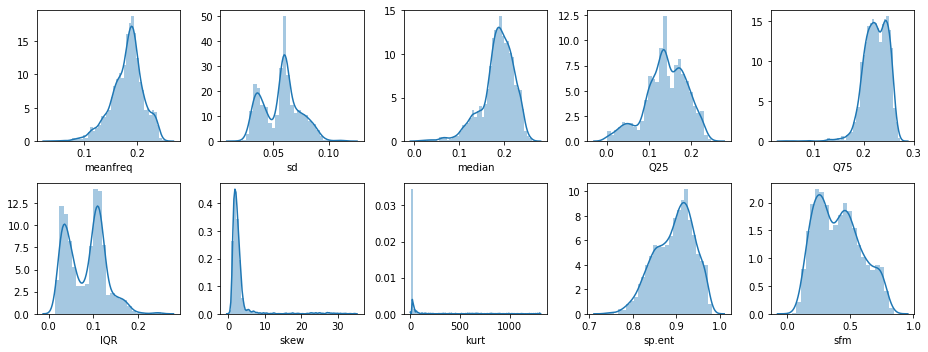

In [9]:
# rapida visualizacion de las variables
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13,5))

for c,ax in zip(df, axes.flatten()):
    sns.distplot(df[c], ax=ax)
    
plt.tight_layout()

# Creacion de Modelos

## Árbol de decisión

In [68]:
#separando y (label) de las variables 
x= df.drop('label', axis=1)
y = df['label']

In [69]:
# Entrenamos un arbol con poca profundidad, para visualizarlo comodamente:
from sklearn.tree import DecisionTreeClassifier
m = DecisionTreeClassifier(max_depth=3)

In [24]:
m

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [70]:
from sklearn.model_selection import train_test_split

# Usamos método "train_test_split" para usar el 20% de la data para validar el modelo.
# El parámetro "random state" nos sirve para poder replicar la misma separación.
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape: {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape: (2534, 20)
Validation shape: (634, 20)


In [76]:
m.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [77]:
# score data de entrenamiento
m.score(x_train,y_train)

0.9711917916337806

In [73]:
predTree = m.predict(x_val)

In [74]:
print(predTree[0:5])
print(y_val[0:5])


['female' 'male' 'male' 'female' 'female']
2148    female
1124      male
170       male
3158    female
2229    female
Name: label, dtype: object


In [78]:
# score data de validacion
m.score(x_val,y_val)

0.9747634069400631

### Visualización de Arbol de Decision

In [82]:
featuresNames = df.columns[0:20]
targetNames = df['label'].unique().tolist()

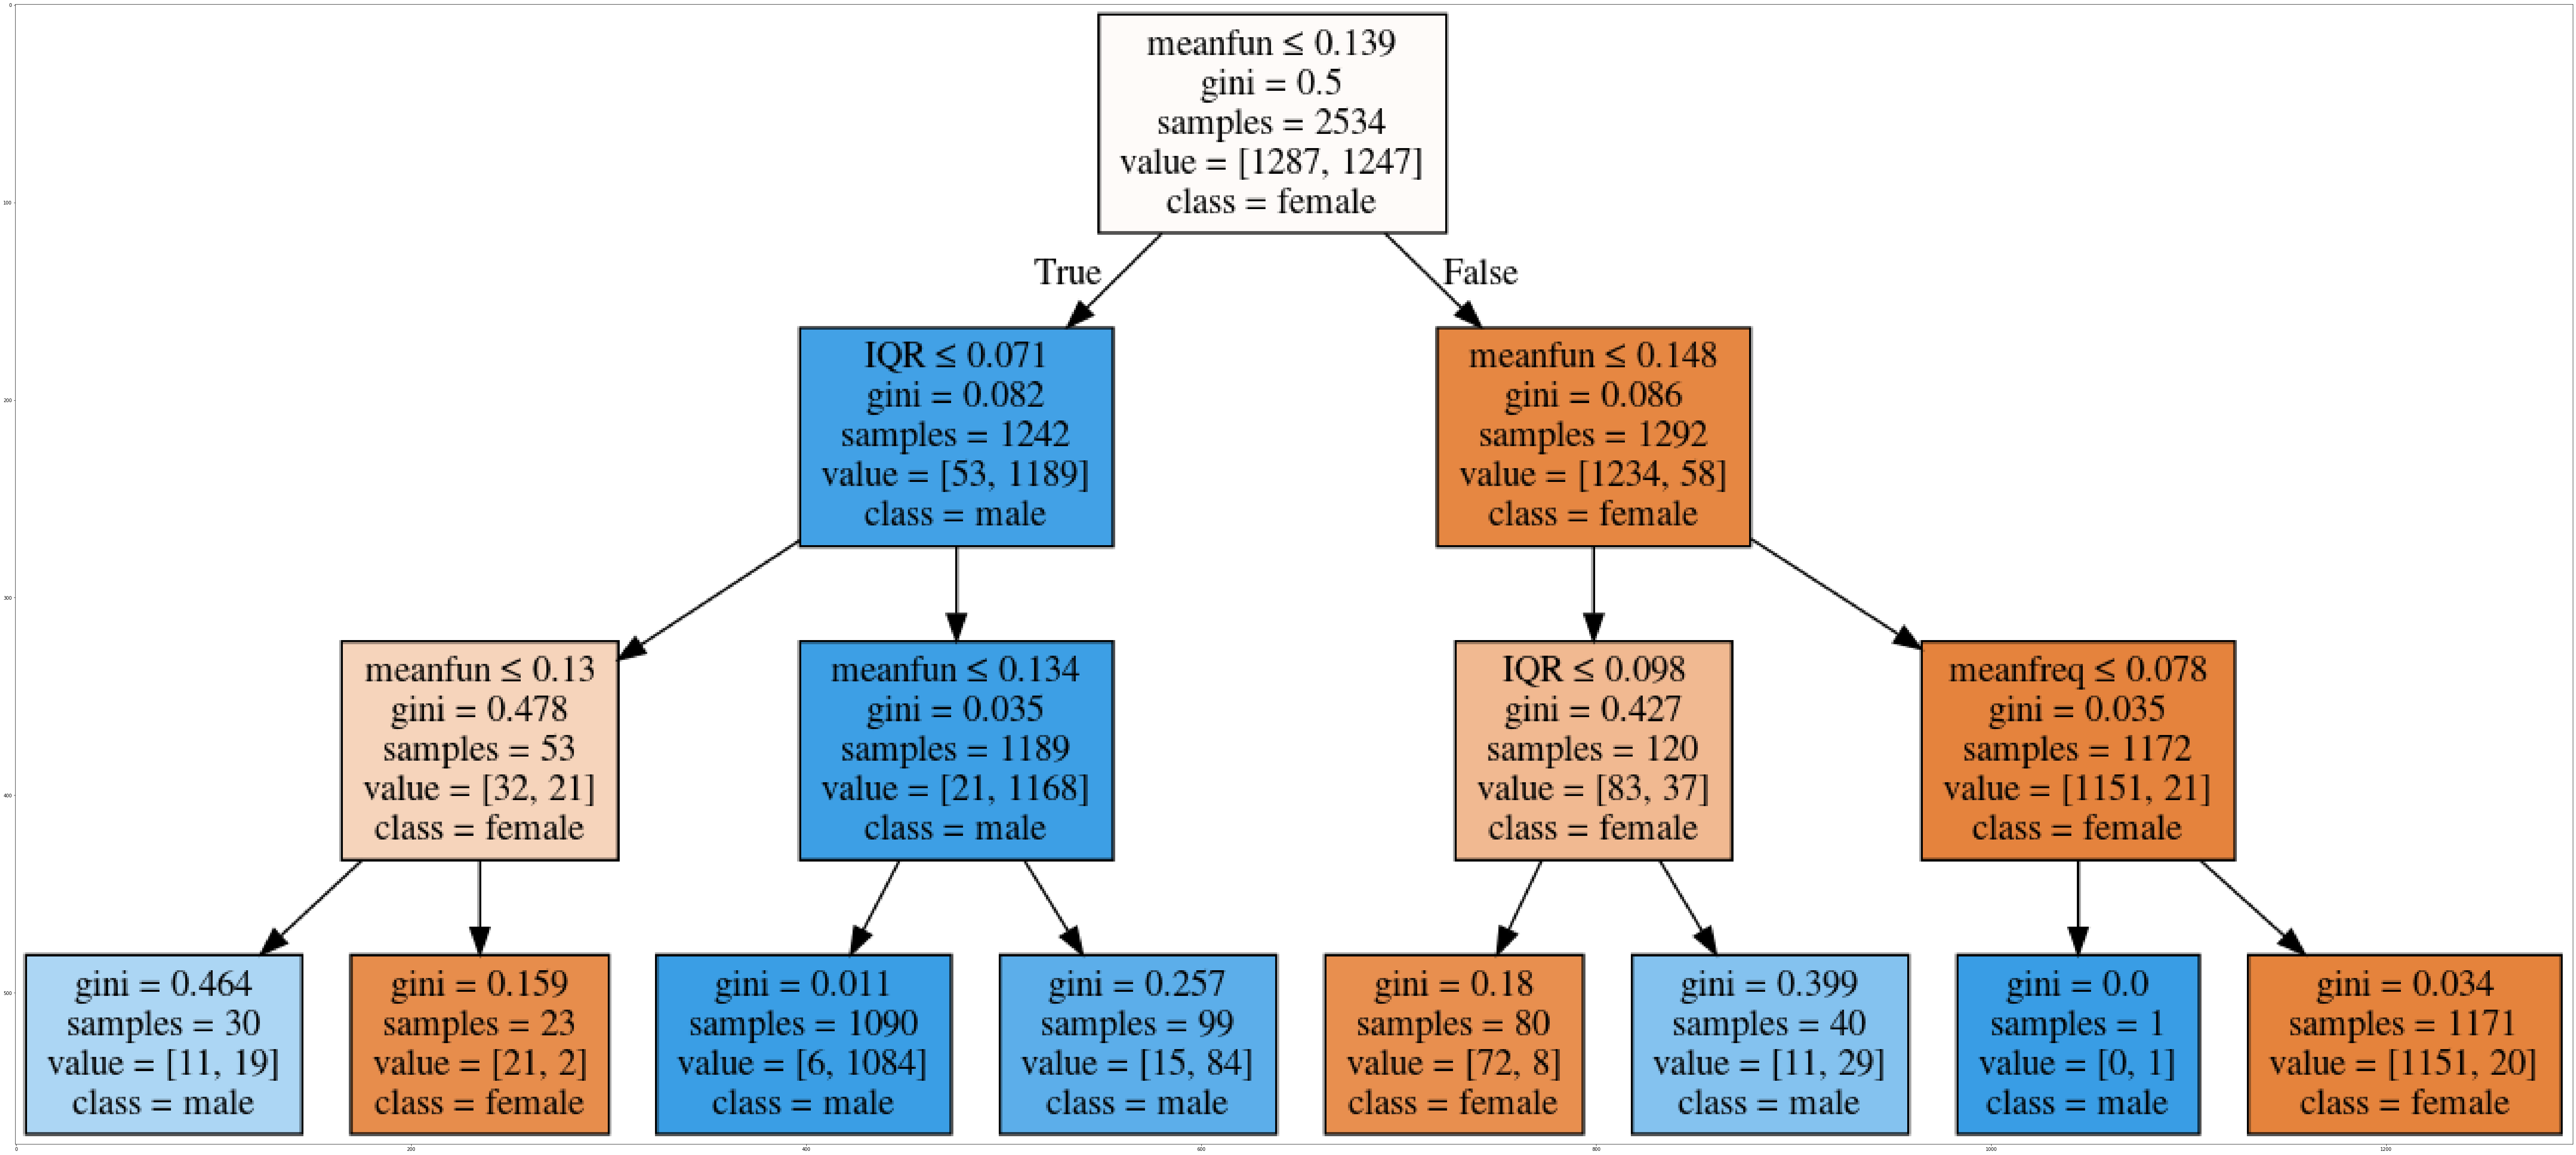

In [83]:
Visualization_tree(m,y_train,featuresNames,targetNames)

## Decision Tree Criterion entropy

In [49]:
voz_tree = DecisionTreeClassifier(criterion = "entropy",max_depth=3)

In [50]:
voz_tree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [52]:
voz_tree.score(x_val,y_val)

0.9763406940063092

### Visualización de Arbol de Decision

In [63]:
featuresNames = df.columns[0:20]
targetNames = df['label'].unique().tolist()

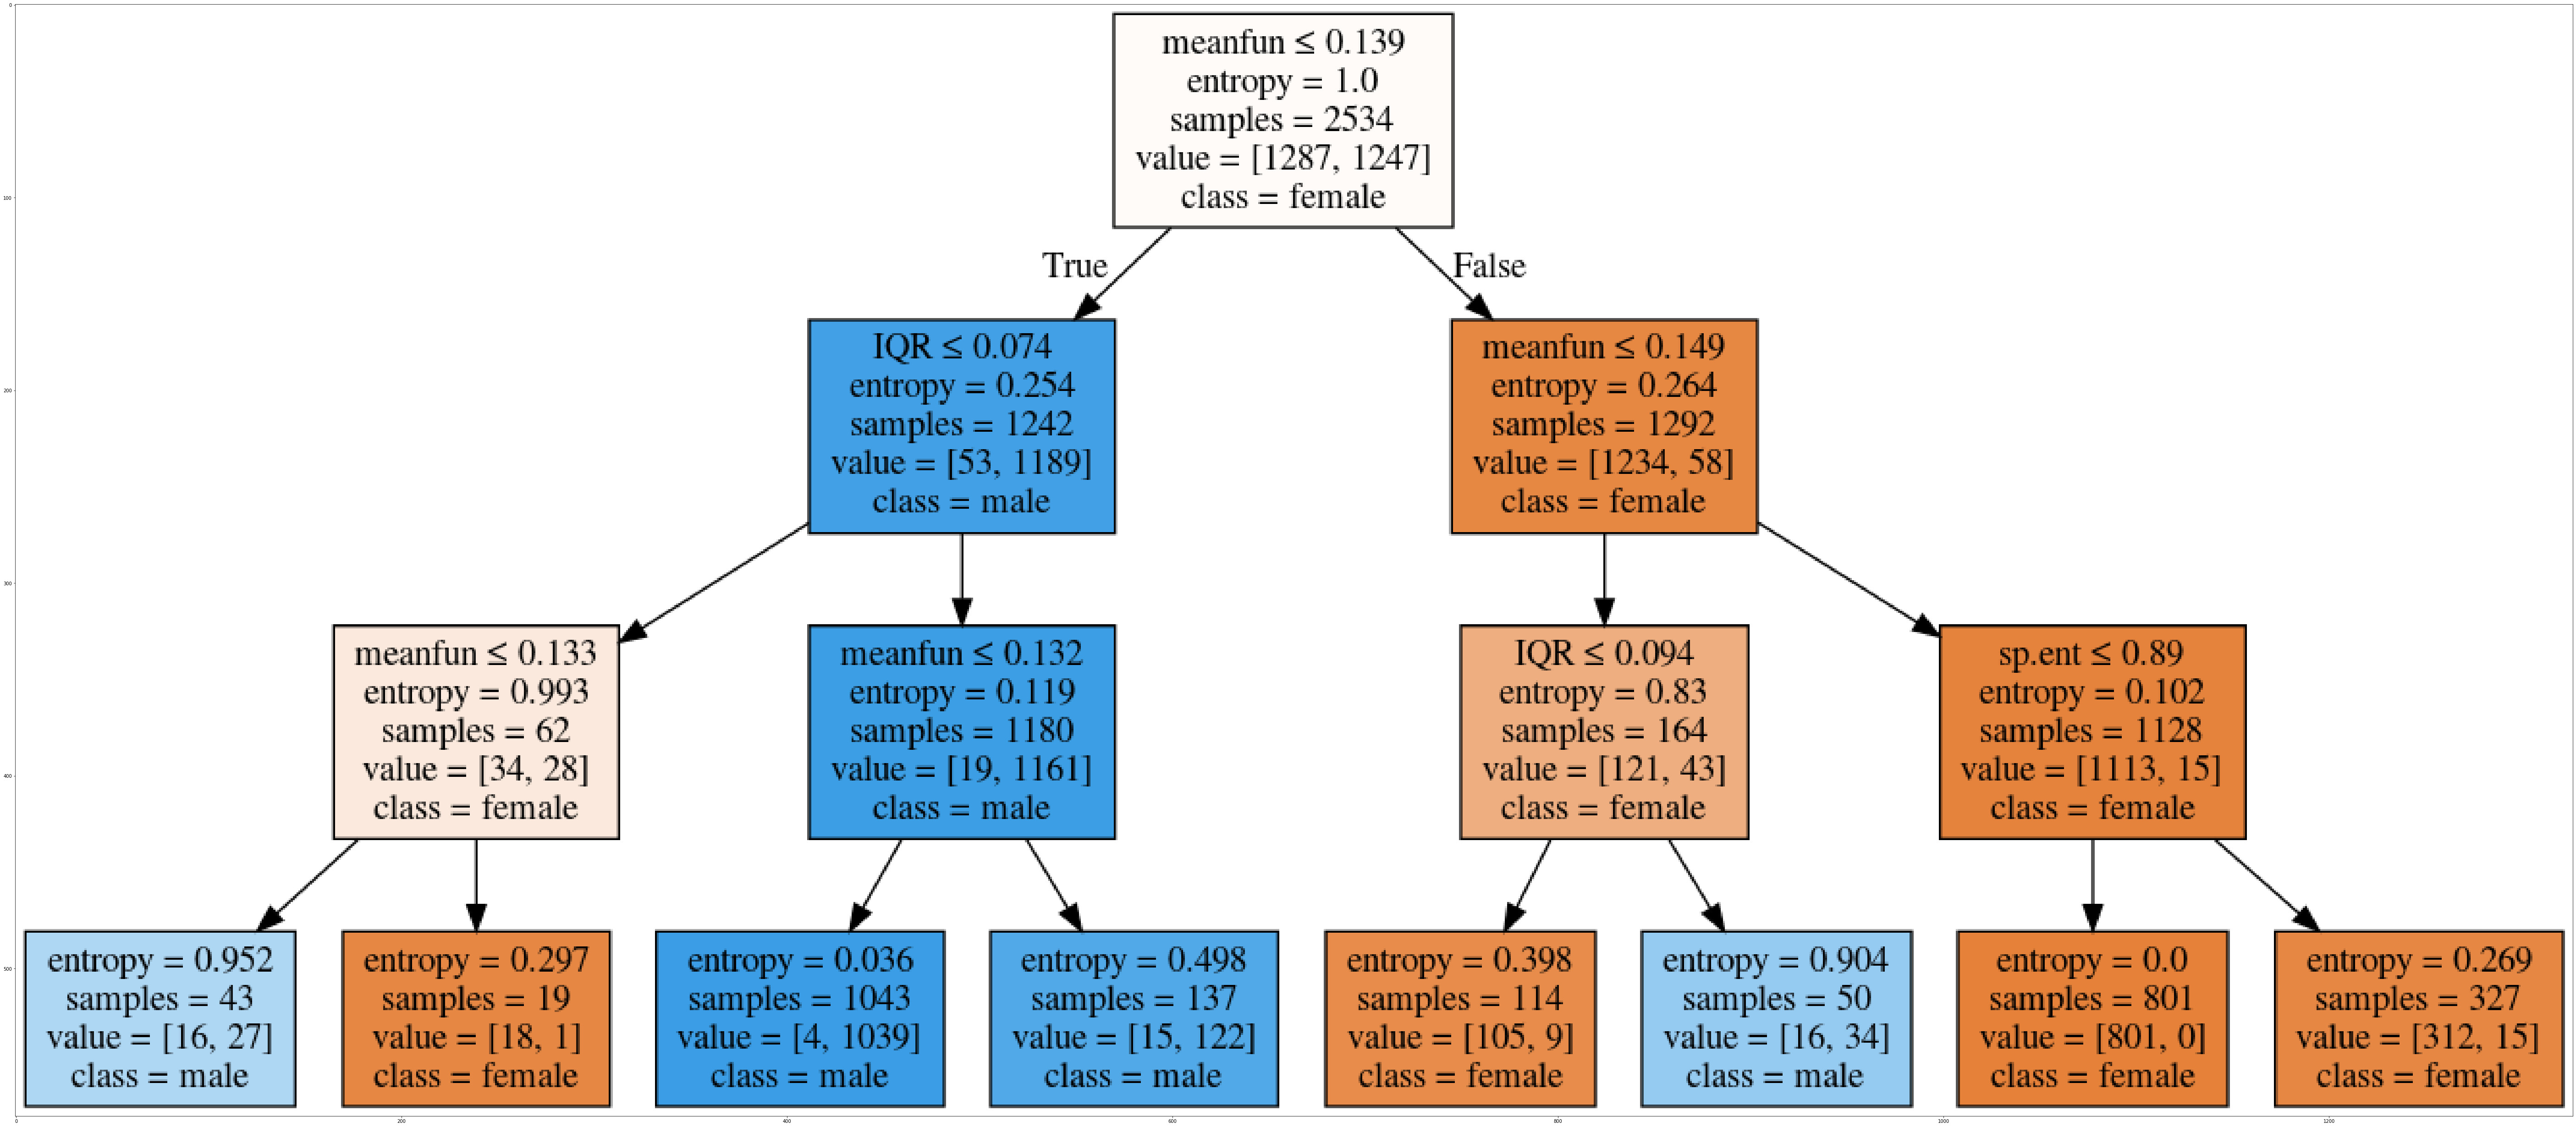

In [86]:
Visualization_tree(voz_tree,y_train,featuresNames,targetNames)

### Confusion Matrix

In [130]:

from sklearn.metrics  import confusion_matrix
yhat = voz_tree.predict(x_val)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_val, yhat))

[[306  13]
 [  6 308]]


In [136]:
cnf_matrix = confusion_matrix(y_val,yhat)

Confusion matrix, without normalization
[[306  13]
 [  6 308]]


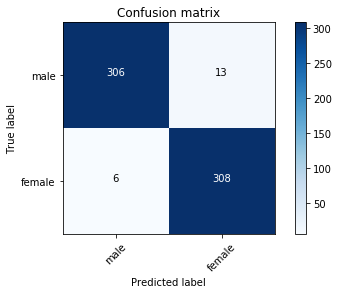

In [135]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['male','female'],normalize= False,  title='Confusion matrix')

## Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=10, n_jobs=-1)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [90]:
# Vamos a definir una función para ver los resultados del entrenamiento.
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
    
score() 

Scores:
Train      = 0.9992
Validation = 0.9858


In [91]:
preds = np.stack([t.predict(x_val) for t in m.estimators_])
print(preds.shape)
preds

(10, 634)


array([[0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.]])

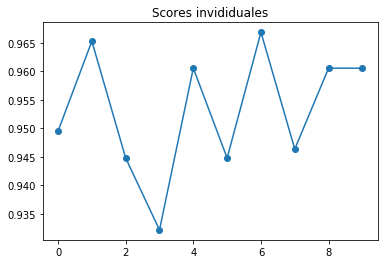

In [92]:
# score de cada árbol
from sklearn.metrics import accuracy_score

accs = [accuracy_score(y_val=='male', p) for p in preds]
plt.plot(accs, '-o')
plt.title('Scores invididuales');

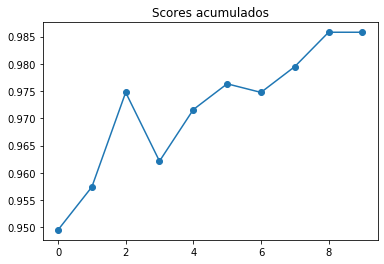

In [93]:
# score acumulado
acum_accs = [accuracy_score(y_val=='male', np.mean(preds[:i+1,:], axis=0) > 0.5) for i in range(len(preds))]
plt.plot(acum_accs, '-o')
plt.title('Scores acumulados');

In [94]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=10,min_samples_split=3,max_features=3, n_jobs=-1)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [95]:
score() 

Scores:
Train      = 0.9992
Validation = 0.9826


In [96]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=10,min_samples_split=5,max_features=3, n_jobs=-1)
m.fit(x_train, y_train)
   
score() 

Scores:
Train      = 0.9992
Validation = 0.9811


In [97]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=500,min_samples_split=10,max_features=3, n_jobs=-1)
m.fit(x_train, y_train)
    
score() 

Scores:
Train      = 0.9976
Validation = 0.9826


In [98]:
# Eliminando variables

x1 = df.drop(['label','sp.ent','maxfun','meandom','mindom','centroid','Q75'], axis=1)
y1 = df['label']

In [99]:
from sklearn.model_selection import train_test_split

# Usamos método "train_test_split" para usar el 20% de la data para validar el modelo.
# El parámetro "random state" nos sirve para poder replicar la misma separación.
x1_train, x1_val, y1_train, y1_val = train_test_split(x1, y1, test_size=0.2, random_state=42)
print(f'Train shape: {x1_train.shape}')
print(f'Validation shape: {x1_val.shape}')

Train shape: (2534, 14)
Validation shape: (634, 14)


In [100]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=1000,min_samples_split=10,max_features=2, n_jobs=-1)
m.fit(x1_train, y1_train)

score() 

Scores:


ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 20 

In [101]:
# analizando variables de importancia
m.feature_importances_

array([0.03472589, 0.09957739, 0.02264552, 0.15759917, 0.17788851,
       0.02797082, 0.01844935, 0.04872677, 0.03664999, 0.32163454,
       0.01185736, 0.01717098, 0.01576478, 0.00933894])

In [102]:
# visualizar importancia en barras
imp = pd.DataFrame({'cols':x1_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
imp.style.bar()
# la media es la variable mas importante segun este indice

,cols,imp
9,meanfun,0.321635
4,IQR,0.177889
3,Q25,0.157599
1,sd,0.0995774
7,sfm,0.0487268
8,mode,0.03665
0,meanfreq,0.0347259
5,skew,0.0279708
2,median,0.0226455
6,kurt,0.0184493


In [103]:
m = RandomForestClassifier(n_estimators=500,min_samples_split=10,max_features=3, oob_score=True)
m.fit(x1_train, y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
# analizando en base al oob_score
m.oob_score_

0.978689818468824

In [105]:
# Vamos a modificar la función score, para incluir el oob score.
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x1_train, y1_train):.4}')
    print(f'Validation = {m.score(x1_val, y1_val):.4}')
    if hasattr(m, 'oob_score_'): print(f'OOB        = {m.oob_score_:.4}')
    
score() 

Scores:
Train      = 0.9961
Validation = 0.9842
OOB        = 0.9787


## PCA

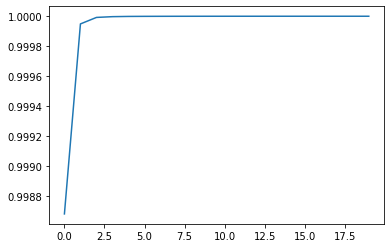

In [106]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [107]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (2534, 20)
Validation shape: (634, 20)


In [108]:
train_pca = pca.transform(x_train)
val_pca   = pca.transform(x_val)

In [47]:
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [109]:
#separando
pos_train_idx = np.where(y_train == 'male')
neg_train_idx = np.where(y_train == 'female')

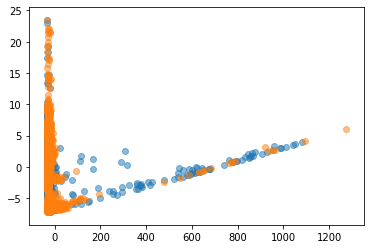

In [110]:
plt.scatter(train_pca[pos_train_idx,0], train_pca[pos_train_idx,1], alpha=0.5)
plt.scatter(train_pca[neg_train_idx,0], train_pca[neg_train_idx,1], alpha=0.5)

In [111]:
from pdpbox import pdp, info_plots
# Ahora veamos como reacciona el modelo a esta variable
pdp_meanfun = pdp.pdp_isolate(m, x_train, x_train.columns, 'meanfun',
                                grid_type='equal')
fig, axes = pdp.pdp_plot(pdp_meanfun, 'meanfun', cluster=True, n_cluster_centers=5)
#axes['pdp_ax'].set_xticks(np.arange(len(education_lbls))+1)
#axes['pdp_ax'].set_xticklabels(education_lbls, rotation=45);

ModuleNotFoundError: No module named 'pdpbox'

In [ ]:
# # REG LOGISTICA
# 

# # Probando el modelo (holdout validation)

In [112]:
from sklearn.model_selection import train_test_split

x = df.drop('label', axis=1)
y = df['label']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (2534, 20)
Validation shape: (634, 20)


In [113]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()
m.fit(x_train, y_train)

/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
score()

Scores:
Train      = 0.9073
Validation = 0.9259


In [115]:

from sklearn.model_selection import train_test_split

x1 = df.drop(['sp.ent', 'maxfun', 'meandom', 'mindom', 'centroid', 'Q75', 'label'], axis=1)
y1 = df['label']

x_train, x_val, y_train, y_val = train_test_split(x1, y1, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')


Train shape     : (2534, 14)
Validation shape: (634, 14)


In [116]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()
m.fit(x_train, y_train)

/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
score()

Scores:
Train      = 0.9025
Validation = 0.9211


## Probando el modelo (Cross Validation)

In [118]:
from sklearn.model_selection import KFold
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

In [119]:
x = df.drop('label', axis=1)
y = df['label']

train_scores, val_scores = [], []

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    m = LogisticRegression()
    m.fit(x_train, y_train)
    score()
    print()
    train_scores.append(m.score(x_train, y_train))
    val_scores.append(m.score(x_val, y_val))

print('=========================')
print(f'Average Scores:')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')

/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Scores:
Train      = 0.9073
Validation = 0.9259

Scores:
Train      = 0.9171
Validation = 0.8864

Scores:
Train      = 0.9132
Validation = 0.8864

Scores:
Train      = 0.9077
Validation = 0.9194

Scores:
Train      = 0.9081
Validation = 0.9305

Average Scores:
Train      = 0.9107
Validation = 0.9097


/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [121]:
x1 = df.drop(['sp.ent', 'maxfun', 'meandom', 'mindom', 'centroid', 'Q75', 'label'], axis=1)
y1 = df['label']

train_scores, val_scores = [], []

for train_idx, val_idx in kfolds.split(x):
    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_val, y_val = x.iloc[val_idx], y.iloc[val_idx]
    m = LogisticRegression()
    m.fit(x_train, y_train)
    score()
    print()
    train_scores.append(m.score(x_train, y_train))
    val_scores.append(m.score(x_val, y_val))

print('=========================')
print(f'Average Scores:')
print(f'Train      = {np.mean(train_scores):.4}')
print(f'Validation = {np.mean(val_scores):.4}')

/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Scores:
Train      = 0.9073
Validation = 0.9259

Scores:
Train      = 0.9171
Validation = 0.8864

Scores:
Train      = 0.9132
Validation = 0.8864

Scores:
Train      = 0.9077
Validation = 0.9194

Scores:
Train      = 0.9081
Validation = 0.9305

Average Scores:
Train      = 0.9107
Validation = 0.9097


/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
